# Answering Business Questions with SQL

### The Chinook DB is a public database, mostly used for educational purposes. In this project, I am using it to explore relational databases via joins and subqueries. Through analyzing the relational database, I will display extraordinary data analysis skills by making business decisions from the SQL query results.

In [1]:
## Creating helper functions

import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def run_query(q):
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql(q, conn)
def run_command(c):
    with sqlite3.connect('chinook.db') as conn:
        conn.isolation_level = None
        cur = conn.cursor()
        cur.execute(c)
        return cur.fetchall()    
def show_tables():
    query = '''SELECT name, type 
    FROM sqlite_master 
    WHERE type IN ('table','view');'''
    return run_query(query)    
print(show_tables())    

                 name   type
0               album  table
1              artist  table
2            customer  table
3            employee  table
4               genre  table
5             invoice  table
6        invoice_line  table
7          media_type  table
8            playlist  table
9      playlist_track  table
10              track  table
11  num_customers_all   view


### 1. Which genres sell the most tracks in the US?

In [2]:
tracks_sold = '''
    SELECT  track_id, SUM(quantity)
    FROM invoice_line 
    GROUP BY track_id 
    LIMIT 10
'''
print(run_query(tracks_sold))

   track_id  SUM(quantity)
0         1              8
1         2              3
2         3              1
3         4              4
4         5              1
5         6             13
6         7              4
7         8              6
8         9              9
9        10              6


In [3]:

q = '''
SELECT g.name genre, 
       SUM(ts.quantity) AS "number of tracks sold"
FROM track tr
INNER JOIN genre g ON g.genre_id = tr.genre_id
INNER JOIN (SELECT  track_id, SUM(quantity) AS quantity
            FROM invoice_line il
            INNER JOIN invoice i ON i.invoice_id = il.invoice_id
            WHERE i.billing_country = "USA"
            GROUP BY track_id) ts 
      ON ts.track_id = tr.track_id
GROUP BY 1
ORDER BY 2 DESC
LIMIT 5;'''

In [4]:
genre_sales_usa = run_query(q)
print(genre_sales_usa)

                genre  number of tracks sold
0                Rock                    561
1  Alternative & Punk                    130
2               Metal                    124
3            R&B/Soul                     53
4               Blues                     36


#### So the number one selling genre in the USA is rock with 561 tracks. 


Text(0, 0.5, 'Number of Tracks Sold')

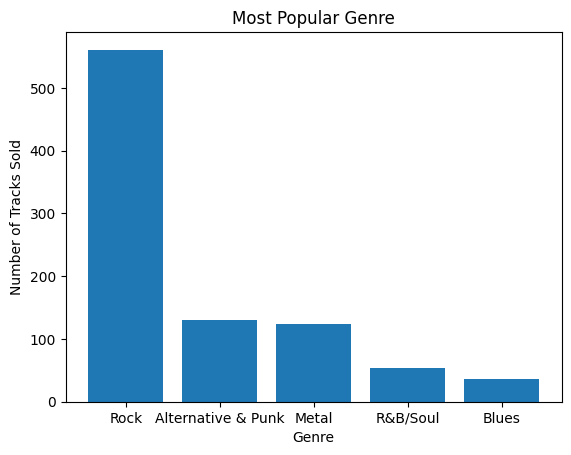

In [5]:
##plotting bar graph to show how much of a difference there is 
##between the popularity of the genres with their sales

plt.bar(genre_sales_usa['genre'], genre_sales_usa['number of tracks sold'])
plt.title("Most Popular Genre")
plt.xlabel("Genre")
plt.ylabel("Number of Tracks Sold")


### 2. How much money in sales did each employee make?

In [6]:
w = '''
SELECT employee_id, title, first_name, last_name, hire_date
FROM employee
'''

employees = run_query(w)
print(employees)

   employee_id                title first_name last_name            hire_date
0            1      General Manager     Andrew     Adams  2016-08-14 00:00:00
1            2        Sales Manager      Nancy   Edwards  2016-05-01 00:00:00
2            3  Sales Support Agent       Jane   Peacock  2017-04-01 00:00:00
3            4  Sales Support Agent   Margaret      Park  2017-05-03 00:00:00
4            5  Sales Support Agent      Steve   Johnson  2017-10-17 00:00:00
5            6           IT Manager    Michael  Mitchell  2016-10-17 00:00:00
6            7             IT Staff     Robert      King  2017-01-02 00:00:00
7            8             IT Staff      Laura  Callahan  2017-03-04 00:00:00


In [7]:
w = '''
SELECT COUNT(customer_id)
FROM customer
WHERE support_rep_id = '1'
'''

employees = run_query(w)
print(employees)

   COUNT(customer_id)
0                   0


In [8]:
x = '''
SELECT (em.title || ' ' || em.first_name || ' ' || em.last_name) 
       AS 'employee name', SUM(i.total) AS "total sales",
       em.hire_date
FROM employee em
INNER JOIN customer c ON c.support_rep_id = em.employee_id
INNER JOIN invoice i ON c.customer_id = i.customer_id
GROUP BY 1
'''

In [9]:
employee_sales = run_query(x)
print(employee_sales)

                       employee name  total sales            hire_date
0   Sales Support Agent Jane Peacock      1731.51  2017-04-01 00:00:00
1  Sales Support Agent Margaret Park      1584.00  2017-05-03 00:00:00
2  Sales Support Agent Steve Johnson      1393.92  2017-10-17 00:00:00


Text(0, 0.5, 'Employee')

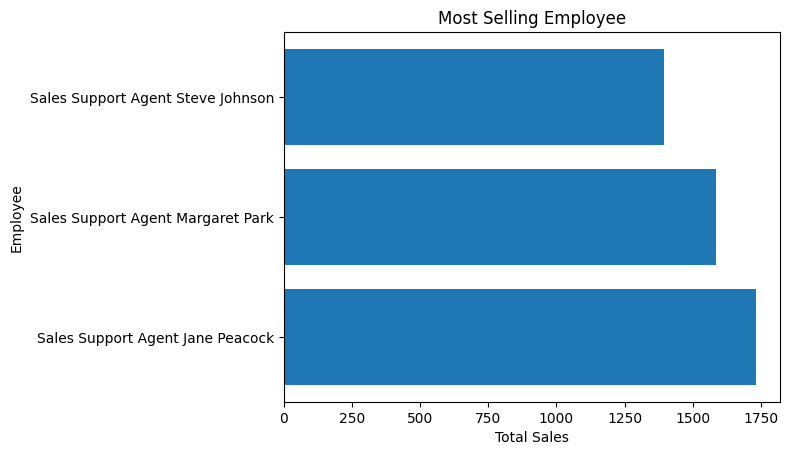

In [10]:
plt.barh(employee_sales['employee name'], employee_sales['total sales'])
plt.title("Most Selling Employee")
plt.xlabel("Total Sales")
plt.ylabel("Employee")

#### In conclusion, the ones that made any sales are the sales support agents, which makes sense since the other employees that are in the employee table are either managers or IT support staff. Also the earlier the employee was hired the more sales they made.

### 3. Analyzing Sales by Country

#### We will be looking for each country: total number of customers, total value of sales, average value of sales per customer, and average order value.

In [11]:
y = '''SELECT COUNT(*) AS 'num customer',
       COUNT(DISTINCT country) AS 'num country'
FROM customer
'''
run_query(y)

,num customer,num country
0,59,24


In [12]:
z = ''' SELECT COUNT(invoice_id)
        FROM invoice
'''
run_query(z)

,COUNT(invoice_id)
0,614


In [13]:
a = '''SELECT c.country, 
           COUNT(c.customer_id) AS 'num_customers', 
           SUM(i.total) AS 'total sales',
         (SUM(i.total)/COUNT(c.customer_id)) AS 'avg sales per customer',
           (SUM(i.avg_order)/COUNT(c.customer_id)) AS 'avg order value'
FROM customer c
INNER JOIN (SELECT customer_id, SUM(total) AS total,
                   (SUM(total)/COUNT(invoice_id)) AS avg_order
             FROM invoice 
             GROUP BY 1
) i ON i.customer_id = c.customer_id
GROUP BY 1
ORDER BY 3 DESC
'''
run_query(a)

,country,num_customers,total sales,avg sales per customer,avg order value
0,USA,13,1040.49,80.037692,8.014750
1,Canada,8,535.59,66.948750,7.416238
2,Brazil,5,427.68,85.536000,6.987485
3,France,5,389.07,77.814000,7.835000
4,Germany,4,334.62,83.655000,8.188750
5,Czech Republic,2,273.24,136.620000,9.377500
6,United Kingdom,3,245.52,81.840000,8.749583
7,Portugal,2,185.13,92.565000,6.527813
8,India,2,183.15,91.575000,8.757692
9,Ireland,1,114.84,114.840000,8.833846


I was supposed to insert conclusion to part 3 here but the reason that there is no conclusion is bcuz i can't figure out how to do the last part which is put all the countries who have '1' in the other category

In [68]:
## creating the 'Other' row

d='''
SELECT country, 
 COUNT(customer_id) AS 'num_customers' 
FROM customer
GROUP BY 1
HAVING  COUNT(customer_id) = 1
'''
run_query(d)

,country,num_customers
0,Argentina,1
1,Australia,1
2,Austria,1
3,Belgium,1
4,Chile,1
5,Denmark,1
6,Finland,1
7,Hungary,1
8,Ireland,1
9,Italy,1


In [3]:
## creating the 'Other' row

d='''
WITH num_customers_1 
AS
    (SELECT country, COUNT(customer_id) AS 'num_customers' 
    FROM customer
    GROUP BY 1
    HAVING  COUNT(customer_id) = 1
    )



SELECT CASE
                   WHEN num_customers = 1 THEN 'Other'
                   END
                   AS 'country',
        SUM(num_customers) AS num_customers

FROM num_customers_1
'''
run_query(d)

,country,num_customers
0,Other,15


In [6]:
## integrating .. ?

d='''
WITH num_customers_2 
AS
    (SELECT country, COUNT(customer_id) AS 'num_customers' 
    FROM customer
    GROUP BY 1
    HAVING  COUNT(customer_id) > 1
    )



SELECT *
FROM num_customers_2
'''
run_query(d)

,country,num_customers
0,Brazil,5
1,Canada,8
2,Czech Republic,2
3,France,5
4,Germany,4
5,India,2
6,Portugal,2
7,USA,13
8,United Kingdom,3


In [34]:
## using a union to combine the 2 above results
d='''
WITH num_customers_1 AS
    (SELECT country, COUNT(customer_id) AS 'num_customers' 
    FROM customer
    GROUP BY 1
    HAVING  COUNT(customer_id) = 1
    ), 
num_customers_2 AS
    (SELECT country, COUNT(customer_id) AS 'num_customers' 
    FROM customer
    GROUP BY 1
    HAVING  COUNT(customer_id) > 1
    )

SELECT country, num_customers
FROM num_customers_2    

UNION ALL
SELECT CASE
                   WHEN num_customers = 1 THEN 'Other'
                   END
                   AS 'country',
        SUM(num_customers) AS num_customers

FROM num_customers_1;
'''
run_query(d)


,country,num_customers
0,Brazil,5
1,Canada,8
2,Czech Republic,2
3,France,5
4,Germany,4
5,India,2
6,Portugal,2
7,USA,13
8,United Kingdom,3
9,Other,15


In [3]:
## so i'm gonna try to integrate the above code in to the whole thing basically yay me

a = '''
WITH num_customers_1 AS
        (SELECT c.country, 
                   COUNT(c.customer_id) AS 'num_customers', 
                   SUM(i.total) AS 'total_sales',
                 (SUM(i.total)/COUNT(c.customer_id)) AS 'avg_sales_per_customer',
                   (SUM(i.avg_order)/COUNT(c.customer_id)) AS 'avg_order_value'
        FROM customer c
        INNER JOIN (SELECT customer_id, SUM(total) AS total,
                           (SUM(total)/COUNT(invoice_id)) AS avg_order
                     FROM invoice 
                     GROUP BY 1
                    ) i ON i.customer_id = c.customer_id
        GROUP BY 1
        HAVING  COUNT(c.customer_id) = 1),

num_customers_2 AS
        (SELECT c.country, 
                    COUNT(c.customer_id) AS 'num_customers', 
                    SUM(i.total) AS 'total sales',
                    (SUM(i.total)/COUNT(c.customer_id)) AS 'avg sales per customer',
                    (SUM(i.avg_order)/COUNT(c.customer_id)) AS 'avg order value'
        FROM customer c
        INNER JOIN (SELECT customer_id, SUM(total) AS total,
                           (SUM(total)/COUNT(invoice_id)) AS avg_order
                     FROM invoice 
                     GROUP BY 1
                    ) i ON i.customer_id = c.customer_id
        GROUP BY 1
        HAVING  COUNT(c.customer_id) > 1
        ORDER BY 2 DESC)

SELECT *
FROM num_customers_2    

UNION ALL
SELECT CASE
                   WHEN num_customers = 1 THEN 'Other'
                   END
                   AS 'country',
        SUM(num_customers) AS num_customers,
        SUM(total_sales) 'total sales', 
        AVG(avg_sales_per_customer) 'avg sales per customer', 
        AVG(avg_order_value) 'avg order value'

FROM num_customers_1

'''
analyze_by_country = run_query(a)
print(analyze_by_country)

          country  num_customers  total sales  avg sales per customer  \
0             USA             13      1040.49               80.037692   
1          Canada              8       535.59               66.948750   
2          France              5       389.07               77.814000   
3          Brazil              5       427.68               85.536000   
4         Germany              4       334.62               83.655000   
5  United Kingdom              3       245.52               81.840000   
6        Portugal              2       185.13               92.565000   
7           India              2       183.15               91.575000   
8  Czech Republic              2       273.24              136.620000   
9           Other             15      1094.94               72.996000   

   avg order value  
0         8.014750  
1         7.416238  
2         7.835000  
3         6.987485  
4         8.188750  
5         8.749583  
6         6.527813  
7         8.757692  
8      

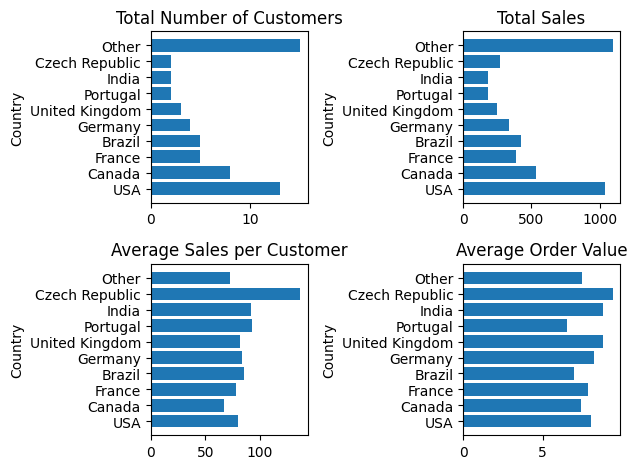

In [17]:
# plt.figure(figsize=(14,12))

plt.subplot(2, 2, 1)
plt.barh(analyze_by_country["country"], analyze_by_country["num_customers"])
plt.title("Total Number of Customers")
# plt.xlabel("Total Number of Customers")
plt.ylabel('Country')

plt.subplot(2, 2, 2)
plt.barh(analyze_by_country["country"], analyze_by_country["total sales"])
plt.ylabel('Country')
# plt.xlabel('Total Sales')
plt.title("Total Sales")

plt.subplot(2, 2, 3)
plt.barh(analyze_by_country["country"], analyze_by_country["avg sales per customer"])
plt.ylabel('Country')
# plt.xlabel('Average Sales per Customer')
plt.title("Average Sales per Customer")

plt.subplot(2, 2, 4)
plt.barh(analyze_by_country["country"], analyze_by_country["avg order value"])
plt.ylabel('Country')
# plt.xlabel('Average Order ')
plt.title("Average Order Value")

plt.tight_layout()


### this is my official conclusion to 3 finally!!
#### just finished making the plots, they are so beautiful
#### USA is in first place for total sales and it's probably because they have the most customers. 

Interestingly, Canada has two-thirds the amount of customers as the USA but it's total sales is half of the USA's, mostly because average sales per customer is pretty low for Canada. 

You might have noticed that the total sales and number of customers chart is pretty similar, that is because having more customers increases your total sales. Furthermore, the average order value and average sales per customer is pretty similar and there isn't much competition between the countries in these two areas, mostly likely because the average consumer buys pretty much the same amount as everybody else.

## 4. Albums vs Individual Tracks

#### The Chinook store allows the customer to either purchase a whole album or purchase a collection of one or more individual tracks. 
#### We want to find out which type of purchase is used more often.

In [22]:
# first, what we need is the track_ids for each invoice 
# so we know which tracks were on each order

run_query('''SELECT invoice_id, track_id FROM invoice_line
             GROUP BY invoice_id
             LIMIT 10''')

# this code chooses the last track from each invoice,
# which is fine, because we can use any track for step 2

,invoice_id,track_id
0,1,1173
1,2,2651
2,3,2646
3,4,2514
4,5,2002
5,6,30
6,7,42
7,8,1560
8,9,196
9,10,3290


In [25]:
# then, we need the album_id for one of the tracks from each  
# order, doesn't matter which track

run_query('''
SELECT il.track_id as tr, t.album_id, il.invoice_id 
FROM track t
INNER JOIN invoice_line il ON il.track_id = t.track_id
WHERE tr = (SELECT track_id FROM invoice_line
                 GROUP BY invoice_id)
LIMIT 10
''')

,tr,album_id,invoice_id
0,1173,91,1
1,1173,91,94
2,1173,91,301
3,1173,91,438


In [11]:
d='''SELECT * FROM track
     WHERE album_id = 163
    LIMIT 20'''
run_query(d)

,track_id,name,album_id,media_type_id,genre_id,composer,milliseconds,bytes,unit_price
0,1986,Intro,163,1,1,Kurt Cobain,52218,1688527,0.99
1,1987,School,163,1,1,Kurt Cobain,160235,5234885,0.99
2,1988,Drain You,163,1,1,Kurt Cobain,215196,7013175,0.99
3,1989,Aneurysm,163,1,1,Nirvana,271516,8862545,0.99
4,1990,Smells Like Teen Spirit,163,1,1,Nirvana,287190,9425215,0.99
5,1991,Been A Son,163,1,1,Kurt Cobain,127555,4170369,0.99
6,1992,Lithium,163,1,1,Kurt Cobain,250017,8148800,0.99
7,1993,Sliver,163,1,1,Kurt Cobain,116218,3784567,0.99
8,1994,Spank Thru,163,1,1,Kurt Cobain,190354,6186487,0.99
9,1995,Scentless Apprentice,163,1,1,Nirvana,211200,6898177,0.99


In [21]:
run_query('''SELECT track_id FROM invoice_line
     WHERE invoice_id = 11
 
  ''')

,track_id
0,2597
1,2203
2,2420
3,2643
4,3072
5,1138
6,2391
7,2257
8,610
9,1419


In [14]:
run_query('''

SELECT invoice_id, 
        CASE WHEN ((SELECT track_id FROM invoice_line
                     WHERE invoice_id = 10
                    EXCEPT
                   SELECT track_id FROM track
                     WHERE album_id = 215) IS NULL
                     AND
                     (SELECT track_id FROM invoice_line
                     WHERE invoice_id = 10
                    EXCEPT
                   SELECT track_id FROM track
                     WHERE album_id = 215) IS NULL) 
             THEN 'album'
             ELSE 'individual tracks'
             END AS 'type of purchase'
  ''')

,track_id,name,album_id,media_type_id,genre_id,composer,milliseconds,bytes,unit_price


## I am not sure what i was even doing with this, let's fix it.

In [13]:
##Let's look directly at which albums each invoice contains.
run_query('''
SELECT i.invoice_id, tr.album_id
FROM invoice i
INNER JOIN invoice_line il ON il.invoice_id = i.invoice_id
INNER JOIN track tr ON tr.track_id = il.track_id
LIMIT 30
  ''')

,invoice_id,album_id
0,1,91
1,1,91
2,1,91
3,1,91
4,1,91
5,1,91
6,1,91
7,1,91
8,1,91
9,1,91


In [7]:
#Now, create a query to count number of track in each album
run_query('''

SELECT album_id, COUNT(track_id) AS "num tracks in album"
FROM track
GROUP BY 1
LIMIT 325

  ''')

,album_id,num tracks in album
0,1,10
1,2,1
2,3,3
3,4,8
4,5,15
...,...,...
320,321,12
321,322,11
322,323,1
323,324,1


In [5]:
#Count the number of tracks in the invoice.
run_query('''
SELECT i.invoice_id, tr.album_id "first album id", COUNT(tr.album_id) "num tracks in invoice"
FROM invoice i
INNER JOIN invoice_line il ON il.invoice_id = i.invoice_id
INNER JOIN track tr ON tr.track_id = il.track_id
GROUP BY 1
LIMIT 30
  ''')


,invoice_id,first album id,num tracks in invoice
0,1,91,16
1,2,322,10
2,3,203,2
3,4,314,8
4,5,163,17
5,6,83,2
6,7,322,11
7,8,183,10
8,9,21,9
9,10,215,2


In [16]:
#Put all together and create a table that compares the number of tracks 
## in the invoice to the number of tracks in the first album as 
## mentioned in the invoice.
q=('''
WITH album_list AS 
    (
    SELECT album_id, COUNT(track_id) AS num_tracks_album
    FROM track
    GROUP BY 1),
    
     invoice_list AS 
    (
    SELECT  i.invoice_id AS invoice_id, 
            tr.album_id first_album_id, 
            COUNT(tr.album_id) num_tracks_invoice
    FROM invoice i
    INNER JOIN invoice_line il ON il.invoice_id = i.invoice_id
    INNER JOIN track tr ON tr.track_id = il.track_id
    GROUP BY 1)
    
SELECT ils.invoice_id, als.album_id, 
        als.num_tracks_album, ils.num_tracks_invoice,
        CASE
        WHEN ils.num_tracks_invoice == als.num_tracks_album
            THEN 'album purchase'
        WHEN ils.num_tracks_invoice != als.num_tracks_album
            THEN 'not album purchase' 
        ELSE 'something else'
        END
        AS 'to album or not'
FROM invoice_list ils
LEFT JOIN album_list als ON als.album_id = ils.first_album_id
ORDER BY 1;
  ''')

to_album_ornot = run_query(q)
print(to_album_ornot)

     invoice_id  album_id  num_tracks_album  num_tracks_invoice  \
0             1        91                16                  16   
1             2       322                11                  10   
2             3       203                17                   2   
3             4       314                 2                   8   
4             5       163                17                  17   
..          ...       ...               ...                 ...   
609         610        83                24                   7   
610         611       215                14                   2   
611         612       182                12                  12   
612         613       153                13                   9   
613         614       215                14                  13   

        to album or not  
0        album purchase  
1    not album purchase  
2    not album purchase  
3    not album purchase  
4        album purchase  
..                  ...  
609  not albu

In [15]:
## checking
run_query('''

SELECT i.invoice_id, tr.album_id
FROM invoice i
INNER JOIN invoice_line il ON il.invoice_id = i.invoice_id
INNER JOIN track tr ON tr.track_id = il.track_id
WHERE i.invoice_id=613

  ''')

,invoice_id,album_id
0,613,153
1,613,214
2,613,257
3,613,221
4,613,321
5,613,233
6,613,221
7,613,88
8,613,157


Text(0.5, 1.0, 'How many are album purchases?')

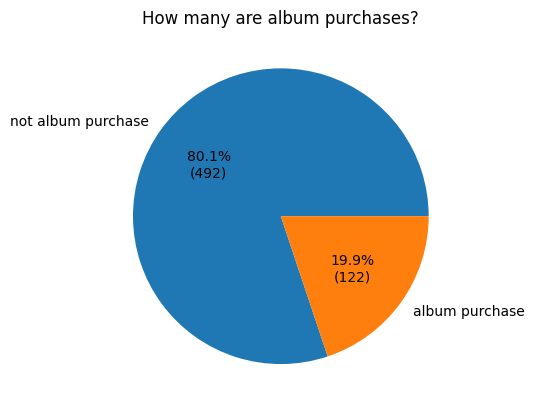

In [23]:
## now to make a nice plot
val_ct_album = to_album_ornot['to album or not'].value_counts()

def autopct_format(values):
        def my_format(pct):
            total = sum(values)
            val = int(round(pct*total/100.0))
            return '{:.1f}%\n({v:d})'.format(pct, v=val)
        return my_format

plt.pie(val_ct_album, labels=val_ct_album.index, autopct=autopct_format(val_ct_album))
plt.title("How many are album purchases?")
# plt.labels('album purchase','not album purchase')

### Full album purchases make up about 20% of all purchases, so I would say it would be wise to keep the option to do an album purchase. Many people probably find it convenient to click on one album instead of selecting tracks.

 ### 